In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor
from sklearn.preprocessing import *
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import *
from sklearn.linear_model import *
from sklearn.metrics import *
from pycaret.regression import *
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import *
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [11]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


In [12]:
print(train.isnull().sum())
test.isnull().sum()

id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      2
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64


id                         0
hour                       0
hour_bef_temperature       1
hour_bef_precipitation     1
hour_bef_windspeed         1
hour_bef_humidity          1
hour_bef_visibility        1
hour_bef_ozone            35
hour_bef_pm10             37
hour_bef_pm2.5            36
dtype: int64

# 전처리

In [13]:
# IterativeImputer 결측치 없애기
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
train_df = train.copy()

colnames=['id','hour',
'hour_bef_temperature',
'hour_bef_precipitation',
'hour_bef_windspeed',
'hour_bef_humidity',
'hour_bef_visibility',
'hour_bef_ozone',
'hour_bef_pm10',
'hour_bef_pm2.5',
'count']

imputer = IterativeImputer(random_state=2021)
df_im = imputer.fit_transform(train_df)
train_df = pd.DataFrame(df_im)
train_df.columns = colnames

train_df = train_df.astype('float64')
train_df = train_df.drop(['id'],axis=1)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   hour                    1459 non-null   float64
 1   hour_bef_temperature    1459 non-null   float64
 2   hour_bef_precipitation  1459 non-null   float64
 3   hour_bef_windspeed      1459 non-null   float64
 4   hour_bef_humidity       1459 non-null   float64
 5   hour_bef_visibility     1459 non-null   float64
 6   hour_bef_ozone          1459 non-null   float64
 7   hour_bef_pm10           1459 non-null   float64
 8   hour_bef_pm2.5          1459 non-null   float64
 9   count                   1459 non-null   float64
dtypes: float64(10)
memory usage: 114.1 KB


In [14]:
test = test.copy()

colnames=['id','hour',
'hour_bef_temperature',
'hour_bef_precipitation',
'hour_bef_windspeed',
'hour_bef_humidity',
'hour_bef_visibility',
'hour_bef_ozone',
'hour_bef_pm10',
'hour_bef_pm2.5',
]

imputer = IterativeImputer(random_state=2021)
df_im = imputer.fit_transform(test)
test = pd.DataFrame(df_im)
test.columns = colnames


test=test.astype('float64')
test=test.drop(['id'],axis=1)
test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   hour                    715 non-null    float64
 1   hour_bef_temperature    715 non-null    float64
 2   hour_bef_precipitation  715 non-null    float64
 3   hour_bef_windspeed      715 non-null    float64
 4   hour_bef_humidity       715 non-null    float64
 5   hour_bef_visibility     715 non-null    float64
 6   hour_bef_ozone          715 non-null    float64
 7   hour_bef_pm10           715 non-null    float64
 8   hour_bef_pm2.5          715 non-null    float64
dtypes: float64(9)
memory usage: 50.4 KB


In [15]:
# 결측치 확인
train_df.isnull().sum()

hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_visibility       0
hour_bef_ozone            0
hour_bef_pm10             0
hour_bef_pm2.5            0
count                     0
dtype: int64

In [16]:
# 이상치 제거하기.

colnames2=['hour',
'hour_bef_temperature',
'hour_bef_precipitation',
'hour_bef_windspeed',
'hour_bef_humidity',
'hour_bef_visibility',
'hour_bef_ozone',
'hour_bef_pm10',
'hour_bef_pm2.5',
]


train_df2 = train_df.copy()

for col in colnames2:
    Q1 = train_df2[col].quantile(0.25)
    Q3 = train_df2[col].quantile(0.75)
    IQR = Q3 - Q1
    print(col , IQR)

# 이상치 값을 NaN으로 변경
    train_df2[col] = np.where((train_df2[col] < Q1 - 1.5*IQR) | (train_df2[col] > Q3 + 1.5*IQR), np.nan, train_df2[col])

# NaN 값이 있는 행 제거
train_df2 = train_df2.dropna()
train_df

hour 12.0
hour_bef_temperature 7.25
hour_bef_precipitation 0.0
hour_bef_windspeed 2.0
hour_bef_humidity 32.5
hour_bef_visibility 1114.0
hour_bef_ozone 0.025117505223920488
hour_bef_pm10 34.0
hour_bef_pm2.5 18.0


,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,20.0,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,13.0,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,6.0,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,23.0,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,18.0,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0
...,...,...,...,...,...,...,...,...,...,...
1454,4.0,16.8,0.0,1.6,53.0,2000.0,0.031,37.0,27.0,21.0
1455,3.0,10.8,0.0,3.8,45.0,2000.0,0.039,34.0,19.0,20.0
1456,5.0,18.3,0.0,1.9,54.0,2000.0,0.009,30.0,21.0,22.0
1457,21.0,20.7,0.0,3.7,37.0,1395.0,0.082,71.0,36.0,216.0


# 모델 적용하기

In [17]:
X = train_df2.drop(['count'],axis=1)
y = train_df2['count']
test_x = test 
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=156)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1034, 9) (1034,) (259, 9) (259,)


# all_estimator

In [18]:
from sklearn.utils import *
rets = all_estimators(type_filter='regressor')

In [19]:

result=[]
for name, estimator_ in rets:
    try:
        model=estimator_()
        model.fit(X_train, y_train)
        pred_y = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test,pred_y))
        result.append((name, round(rmse, 2)))
    except Exception:
        pass

sorted(result, key=lambda x : x[1], reverse=False)



[('ExtraTreesRegressor', 40.14),
 ('HistGradientBoostingRegressor', 41.63),
 ('RandomForestRegressor', 42.39),
 ('GradientBoostingRegressor', 43.84),
 ('BaggingRegressor', 44.3),
 ('AdaBoostRegressor', 48.22),
 ('Lars', 56.12),
 ('LinearRegression', 56.12),
 ('TransformedTargetRegressor', 56.12),
 ('LassoLarsIC', 56.14),
 ('LarsCV', 56.15),
 ('LassoLarsCV', 56.15),
 ('RidgeCV', 56.16),
 ('ARDRegression', 56.22),
 ('Ridge', 56.29),
 ('BayesianRidge', 56.33),
 ('Lasso', 56.34),
 ('ElasticNet', 56.4),
 ('KernelRidge', 56.52),
 ('OrthogonalMatchingPursuitCV', 56.57),
 ('PLSRegression', 57.17),
 ('TweedieRegressor', 57.18),
 ('TheilSenRegressor', 57.24),
 ('LassoCV', 57.25),
 ('MLPRegressor', 57.68),
 ('DecisionTreeRegressor', 58.25),
 ('HuberRegressor', 58.82),
 ('LinearSVR', 59.33),
 ('RANSACRegressor', 60.36),
 ('ElasticNetCV', 60.41),
 ('ExtraTreeRegressor', 61.08),
 ('PassiveAggressiveRegressor', 62.67),
 ('KNeighborsRegressor', 68.43),
 ('OrthogonalMatchingPursuit', 69.19),
 ('CCA', 7

In [20]:
exp = setup(train_df2, target='count',normalize=True)

,Description,Value
0,session_id,1147
1,Target,count
2,Original Data,"(1293, 10)"
3,Missing Values,False
4,Numeric Features,9
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(905, 9)"


In [21]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,25.9298,1469.1069,38.1582,0.7842,0.4604,0.4254,0.0980
et,Extra Trees Regressor,25.4228,1471.6337,38.1563,0.7839,0.4127,0.4150,0.1880
rf,Random Forest Regressor,26.7634,1587.6156,39.6822,0.7670,0.4148,0.4126,0.2210
gbr,Gradient Boosting Regressor,27.3350,1603.6675,39.9050,0.7645,0.4462,0.4657,0.1150
knn,K Neighbors Regressor,34.4497,2283.8918,47.6397,0.6642,0.5796,0.6335,0.0110
ada,AdaBoost Regressor,38.8296,2313.0095,47.9733,0.6622,0.6648,0.9115,0.0970
br,Bayesian Ridge,39.2819,2706.5226,51.9225,0.6040,0.7007,0.7654,0.0120
lasso,Lasso Regression,39.3586,2707.0860,51.9335,0.6039,0.6805,0.7709,0.0120
ridge,Ridge Regression,39.2736,2707.1846,51.9289,0.6039,0.6982,0.7630,0.0110
lr,Linear Regression,39.2729,2707.3010,51.9301,0.6038,0.6978,0.7628,1.4900


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=1147, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [22]:
# StandardScaler 
kf = KFold(n_splits=5)

def SS_model(df):
    model = make_pipeline(StandardScaler(),df())
    model.fit(X_train,y_train)
    pred_y = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,pred_y))
    print(df(),'rmse : ', round(rmse,1))

SS_model(DecisionTreeRegressor)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
SS_model(ExtraTreeRegressor)
SS_model(BaggingRegressor)
SS_model(RandomForestRegressor)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best') rmse :  57.4
ExtraTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                   max_features='auto', max_leaf_nodes=None,
                   min_impurity_decrease=0.0, min_impurity_split=None,
                   min_samples_leaf=1, min_samples_split=2,
                   min_weight_fraction_leaf=0.0, random_state=None,
                   splitter='random') rmse :  56.5
BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state

In [23]:
# MinMaxScaler

def MM_model(df):
    model = make_pipeline(MinMaxScaler(),df())
    model.fit(X_train,y_train)
    pred_y = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,pred_y))
    print(df(),'rmse : ', round(rmse,1))

SS_model(DecisionTreeRegressor)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
SS_model(ExtraTreeRegressor)
SS_model(BaggingRegressor)
SS_model(RandomForestRegressor)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best') rmse :  56.2
ExtraTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                   max_features='auto', max_leaf_nodes=None,
                   min_impurity_decrease=0.0, min_impurity_split=None,
                   min_samples_leaf=1, min_samples_split=2,
                   min_weight_fraction_leaf=0.0, random_state=None,
                   splitter='random') rmse :  60.0
BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state

In [24]:
# RobustScaler

def RS_model(df):
    model = make_pipeline(RobustScaler(),df())
    model.fit(X_train,y_train)
    pred_y = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,pred_y))
    print(df(),'rmse : ', round(rmse,1))

SS_model(DecisionTreeRegressor)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
SS_model(ExtraTreeRegressor)
SS_model(BaggingRegressor)
SS_model(RandomForestRegressor)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best') rmse :  56.5
ExtraTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                   max_features='auto', max_leaf_nodes=None,
                   min_impurity_decrease=0.0, min_impurity_split=None,
                   min_samples_leaf=1, min_samples_split=2,
                   min_weight_fraction_leaf=0.0, random_state=None,
                   splitter='random') rmse :  61.8
BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state

In [25]:
# prediction=np.zeros((10000, 3)) 
# # 모델생성 - 랜덤포레스트
# Rf = RandomForestClassifier()                                                   m
# # k-Fold 교차 검증 수행
# for train_idx, test_idx in kf.split(train_x):
#     X_train, y_train = train_x.iloc[train_idx], train_y.iloc[train_idx]
#     X_test, y_test = train_x.iloc[test_idx], train_y.iloc[test_idx]
#     Rf.fit(X_train,y_train) # 교차검증 후 모델에 적용

#     prediction += Rf.predict_proba(test_x)/5

# prediction

In [26]:
# 가장 rmse 작은 모델 submission 저장
model = make_pipeline(RobustScaler(),RandomForestRegressor())

prediction = np.zeros((test_x.shape[0],2))
prediction.shape
for train_idx, test_idx in kf.split(X):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    model.fit(X,y)
    pred_y = model.predict(test_x)
submission = pd.read_csv('submission.csv')
submission['count'] = pred_y
submission.to_csv('jang4.csv',index = False)

In [27]:
model_feat = RandomForestRegressor()
model = make_pipeline(MinMaxScaler(),model_feat)

model.fit(X,y)
pred_y = model.predict(test_x)
submission = pd.read_csv('submission.csv')
submission['count'] = pred_y
submission.to_csv('jang67.csv',index = False)

In [28]:
model_feat = ExtraTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                   max_features='auto', max_leaf_nodes=None,
                   min_impurity_decrease=0.0, min_impurity_split=None,
                   min_samples_leaf=1, min_samples_split=2,
                   min_weight_fraction_leaf=0.0, random_state=None,
                   splitter='random')

model = make_pipeline(MinMaxScaler(),model_feat)

model.fit(X,y)
pred_y = model.predict(test_x)
submission = pd.read_csv('submission.csv')
submission['count'] = pred_y
submission.to_csv('jang678.csv',index = False)

In [29]:
model = RandomForestRegressor()
param = [
        {'n_estimators': [3, 10, 30,50,100,1000], 'max_features': [2, 4, 6, 8]},
        {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
        {'max_depth' : [8,16,24], 'min_samples_leaf':[1,6,12]},
    ]

grid = GridSearchCV(model, param_grid=param,cv=2,n_jobs=-1)    

In [30]:
grid.fit(X,y)

GridSearchCV(cv=2, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

<function matplotlib.pyplot.show(close=None, block=None)>

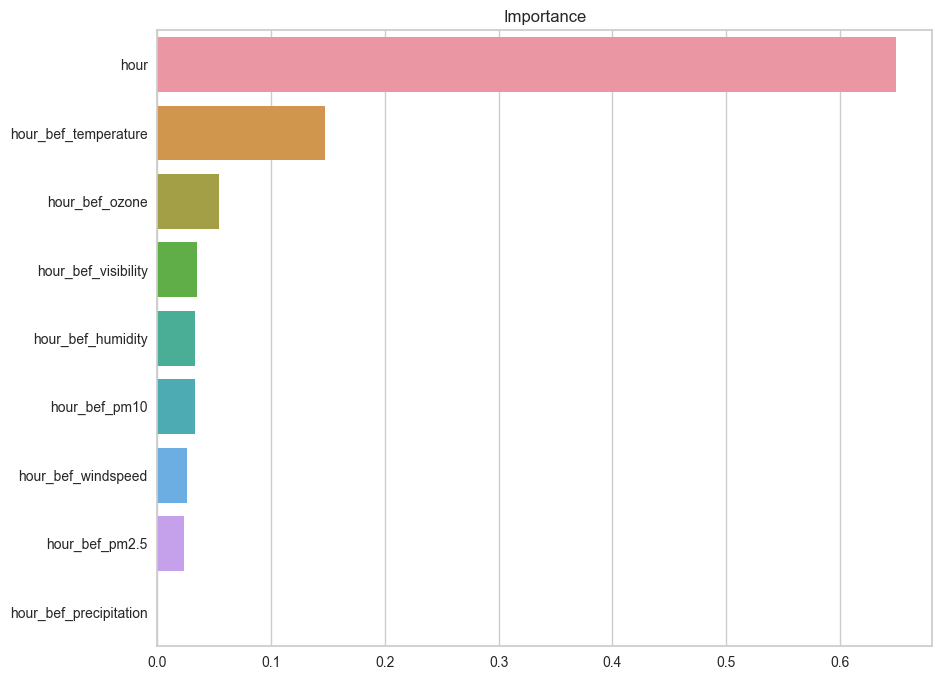

In [31]:
model = RandomForestRegressor()
model.fit(X,y)

importance_val = model.feature_importances_
impotance = pd.Series(importance_val,index=X_train.columns)
top20 = impotance.sort_values(ascending=False)[:20]
plt.figure(figsize=(10,8))
plt.title('Importance')
sns.barplot(x=top20, y=top20.index)
plt.show

In [32]:
grid.best_params_,grid.best_score_

({'max_depth': 24, 'min_samples_leaf': 1}, 0.7587268483893225)

In [33]:
%pwd

'd:\\Big_data_gonggong\\ML_study.ipynb\\ML_Bike'